In [1]:
] activate .

  Activating project at `~/Projects/HTM/Notebooks`


In [1]:
] add SparseArrays

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Projects/HTM/Notebooks/Project.toml`
  [2f01184e] + SparseArrays
  No Changes to `~/Projects/HTM/Notebooks/Manifest.toml`


# Simplifying HTM
#### Can the reduction of HTM to random projection without threshold and linear classifier solve the taxicab problem?

We make an analogy of HTM to random projection by considering each segment a random high dimensional vector. Because HTM thresholds the segment activations and cells enter a predictive state when segments are active beyond the threshold, we can model segment activation as random projection.

#### What if we add a fixed non-linear thresholder


#### What if we add a neural net to the end?

In [2]:
using CSV
using Distances: sqeuclidean
using Flux
using Flux: mse
using LinearAlgebra
using Plots
using SparseArrays
using Shrike: random_projections
using StatsBase
using Zygote


In [3]:
mutable struct TMParams
    num_cols
    cells_per_col
    seg_per_cell
    syn_per_seg
    permenance_incr
    permenance_decr
    small_perm_decr
    theta
end

TMParams(;
    num_cols=2048, 
    cells_per_col=32, 
    seg_per_cell=64, 
    syn_per_seg=32,
    permenance_incr=0.36,
    permenance_decr=0.05,
    small_perm_decr=0.01,
    theta=16
) = TMParams(
    num_cols,
    cells_per_col,
    seg_per_cell,
    syn_per_seg,
    permenance_incr,
    permenance_decr,
    small_perm_decr,
    theta
)

TMParams

In [4]:
ps = TMParams()

TMParams(2048, 32, 64, 32, 0.36, 0.05, 0.01, 16)

A cell enters the predictive state if one of its segments is active.

If cell `c` was predictive and then became active, we reenforce the segments that caused it to become active.

If the the winning column was not predicted, then we pick the cell in the column that was closest to being active.

What does this do? It organizes the network into 

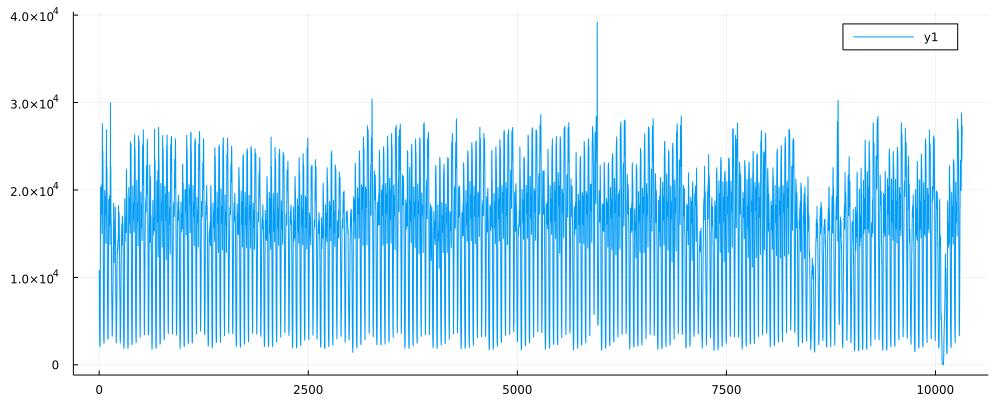

In [3]:
csv = CSV.File("../nyc_taxi.csv")
X = csv["value"]
plot(X, size=(1000, 400))

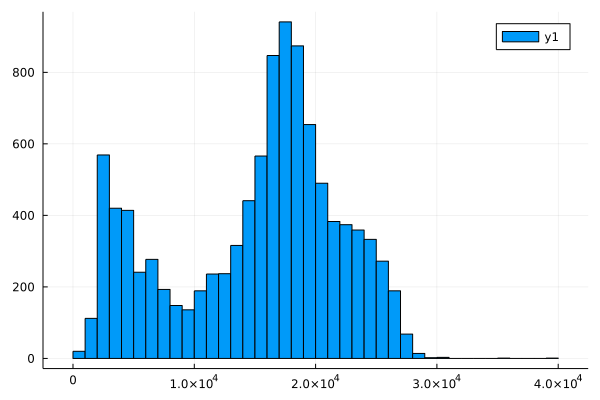

In [4]:
histogram(X)

In [6]:
"""
    which_bin(x, bin_width, start, stop)

Assumes a set of intervals with width `bin_width` between 
`start` and `stop`. Returns the index which interval
`x` belongs to.
"""
function which_bin(x, bin_width, start, stop)
    if x > stop 
        i = floor(Int, (stop - start) / bin_width)
    elseif x < start
        i = 0
    else
        i = floor(Int, (x - start) / bin_width)
    end
    return i + 1
end

# Make evenly spaced intervals for taxi data
num_bins = 101
bins = LinRange(minimum(X), maximum(X), num_bins)
bin_size = bins[2] - bins[1]

# Make a function that assigns data to the appropriate bin index
taxi_bin(x) = which_bin(x,  bin_size, bins.start, bins.stop)

taxi_bin (generic function with 1 method)

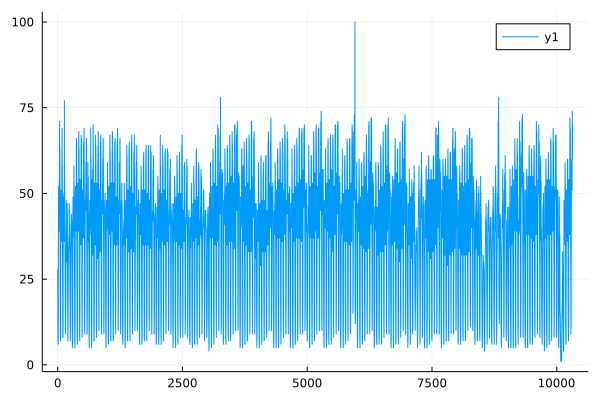

In [7]:
Z = map(taxi_bin, X)
plot(Z)

In [37]:
enc_len = 1024
enc_active = 32
encodings = Dict(i => sample(1:enc_len, enc_active; replace=false) for i in 1:(num_bins + 1));

In [38]:
train_len = 7500
train_SDR = zeros(enc_len, train_len)

for i in 1:train_len
    active = encodings[taxi_bin(X[i])]
    train_SDR[active, i] .= 1.0
end

# Purely Linear Version

In [39]:
function kwta(x::Array{T, 1}, k) where T           
    partial_sort = sortperm(
        x,
        rev=true,
        alg=PartialQuickSort(k)
    )
    winners = partial_sort[1:k]
    output = zeros(T, size(x))
    output[winners] = x[winners]
    return output
end 
    

kwta (generic function with 1 method)

In [99]:
mutable struct RandomProjEnsamble{T}
    input_len::Int
    regularization::T
    rp_matrices::Array{Array{T, 2}, 1}
    mappings::Array{Array{T, 2}, 1}
end

function RandomProjEnsamble(
        input_len, 
        ensamble_size, 
        vectors_per_projection; 
        regularization=1e-6, T=Float64
)
    rp_matrices = [random_projections(T, input_len, vectors_per_projection) for i in 1:ensamble_size]
    mappings = [zeros(T, input_len, vectors_per_projection) for i in 1:ensamble_size]
    return RandomProjEnsamble(input_len, regularization, rp_matrices, mappings)
end

function train!(rpe::RandomProjEnsamble, X::AbstractArray, Y::AbstractArray)
    if first(size(X)) != rpe.input_len
        error("First dimension of input to RandomProjectionEnsemble must be $(rpe.input_len)")
    end
    
    for (i, rp) in enumerate(rpe.rp_matrices)
        proj = rp * X
        # Tikhanov regression
        rpe.mappings[i] .= Y * inv(proj' * proj - rpe.regularization * I) * proj'
        # Include random projection in the mapping 
        rpe.mappings[i] *= rp
    end
    # Delete random projections since they are included in mappings
    rpe.rp_matrices = [zeros(1,1)]
end

function (rpe::RandomProjEnsamble)(X::AbstractArray)
    pred = map(m -> m * X, rpe.mappings)
    return pred
end    

function Base.show(io::IO, rpe::RandomProjEnsamble)
    print(io, "RandomProjectionEnsamble(\n\tinput_len=$(rpe.input_len)\n)")
end

### Initialize and Train

In [131]:
input_len = enc_len
ensamble_size = 1
projection_size = 1024
rpe = RandomProjEnsamble(input_len, ensamble_size, projection_size)

train!(rpe, train_SDR[:, 1:(end-1)], train_SDR[:, 2:end]);

### Predict via kwinners

In [132]:
agg_pred = sum(pred)

pred = rpe(train_SDR[:, 1:(end-1)])
active_cols = mapslices(x->kwta(x, enc_active), agg_pred, dims=1)
active_cols = Float64.(active_cols .!= 0)

# Check average error per column
differences = sum(abs.(active_cols .- train_SDR[:, 2:end]), dims=1)
accuracy = mean(1 .- differences ./ (2 * enc_active))

0.23515635418055741

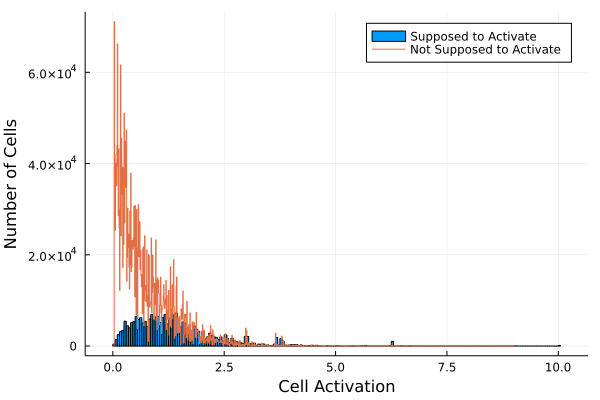

In [133]:
true_targets = Bool.(train_SDR[:, 2:end])
correct = agg_pred[true_targets]
incorrect = agg_pred[ .~ true_targets]
histogram(correct, label="Supposed to Activate")
histogram!(incorrect[incorrect .> 0.01], label="Not Supposed to Activate")
xlabel!("Cell Activation")
ylabel!("Number of Cells")

# Add Thresholding (Non-linear)

In [134]:
function get_accuracy()
    pred = net(transformed_data)
    active_cols = mapslices(x->kwta(x, enc_active), pred, dims=1)
    differences = sum(abs.(active_cols .- targets), dims=1)
    acc = mean(1 .- differences ./ (2 * enc_active))
    return acc
end

function get_accuracy_oneshift()
    pred = net(transformed_data)
    active_cols = mapslices(x->kwta(x, enc_active), -1. * abs.(pred .- 1.), dims=1)
    differences = sum(abs.(active_cols .- targets), dims=1)
    acc = mean(1 .- differences ./ (2 * enc_active))
    return acc
end

get_accuracy_oneshift (generic function with 1 method)

In [135]:
net = Chain(
    Dense(projection_size * ensamble_size, enc_len, σ)
)

loss(X, Y) = mse(net(X), Y)

transformed_data = rpe(train_SDR[:, 1:(end-1)])
transformed_data = vcat(transformed_data...)
targets = train_SDR[:, 2:end]

opt = ADAM()
data = [(transformed_data, targets)];

In [136]:
@time for i in 1:100
    Flux.Optimise.train!(loss, Flux.params(net), data, opt)
    println(get_accuracy(), "\t", get_accuracy_oneshift())
end

0.24994651522779285	0.264241585869716
0.2538329776996734	0.26013435567838017
0.25772160531207744	0.2560248726480761
0.2616089215750206	0.2519168217765039
0.26549136570400417	0.2478139776137068
0.26936531044245404	0.24372018538417725
0.2732428916055059	0.2396393429258503
0.277088505884878	0.23557538162820058
0.28094328889244474	0.23153223797218606
0.28474920902408035	0.2275138348484657
0.288551687770564	0.22352406190935115
0.29240669473753217	0.21956677807020714
0.29611672092628955	0.21564572114192895
0.2999586801083406	0.21176459301552972
0.3037011936173767	0.20792690758602028
0.3072947741651697	0.20413600049136252
0.3110381110864655	0.2003951243906185
0.31456248485888033	0.19670747711413059
0.3181804615720662	0.19307585757487528
0.3216758795100958	0.1895028687105955
0.32533627422695777	0.18599111330230264
0.3288480420132004	0.18254282388669404
0.33234134295771783	0.1791604087693623
0.3359067400306123	0.1758457990164971
0.3392931234846612	0.17260090555140867
0.34247863645526	0.16942647

In [137]:
net

Chain(
  Dense(1024 => 1024, σ),               # 1_049_600 parameters
) 

In [138]:
get_accuracy()

0.4492409233333926

In [129]:
9173.701429 / (60 * 60)

2.5482503969444448

In [157]:
E = zeros(num_bins, enc_len)
for i in 1:num_bins
    E[i, encodings[i]] .= 1.0
end

In [164]:
closest_encoding(x) = mapslices(e -> sqeuclidean(x, e), E, dims=2) |> argmin |> Tuple |> first
Y_pred = net(transformed_data)
bin_pred = mapslices(closest_encoding, Y_pred, dims=1)
true_bin = mapslices(closest_encoding, train_SDR[:, 2:end], dims=1)
true_bin_sanity_check = map(taxi_bin, X[2:train_len]);

In [165]:
bin_pred

1×7499 Matrix{Int64}:
 42  17  9  9  9  7  6  6  6  6  6  9  …  44  17  14  12  9  7  6  7  6  6

In [166]:
true_bin

1×7499 Matrix{Int64}:
 21  16  12  10  8  7  6  6  6  7  12  …  23  18  14  10  8  7  8  7  7  12

In [167]:
reshape(true_bin_sanity_check, 1, :)

1×7499 Matrix{Int64}:
 21  16  12  10  8  7  6  6  6  7  12  …  23  18  14  10  8  7  8  7  7  12

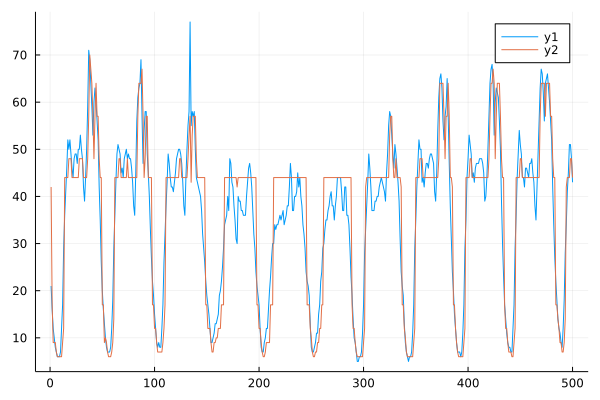

In [170]:
plot(reshape(true_bin, :)[1:500])
plot!(reshape(bin_pred, :)[1:500])

Hyper parameter explorer for julia.

Inputs: `X`, `Y`, one of `["Dense", "LSTM", "CNN"]` and `--gpu 1`

## Neural net to approximate derivative